In [1]:
#!pip install yfinance
#import yfinance as yf
#!pip install mplfinance
#!pip install pytorch-
#!pip install pandas_ta
#! pip install statsforecast s3fs datasetsforecast
#!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Activation
from keras import optimizers
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Basic Forecasting with LSTM


Models envisioned:
- LSTM > ARIMA (2018): LSTM are better-suited for sequential data like financial time series since they can capture long-term dependencies and patterns in the data,


!!! Trading is more than price prediction: transaction cost, market liquidity, investor’s risk-aversion… These external factors make Reinforcement Learning more accurate than supervised learning for finance forecasting. RL is typically used in scenarios where an agent learns to interact with an environment to achieve a goal.

- RL+LSTM: building trading strategies and portfolio management
- DRL+LSTM (2022) provides portfolio scalability + market model independence
- LSTM+GARCH (2023) improves forecasting w/ volatility measures (crypto++)
- GARCH-EVT (Extreme Value Theory) is also powerful for high volatility.



To predict market tendencies based on financial data of multiple companies, I need:
- a Feature Matrix (X) containing the financial data of all companies
- a Target Vector (y) representing market tendencies


### LSTM closing price prediction
https://www.youtube.com/watch?v=hpfQE0bTeA4


In [ ]:
# import dataset
files.upload()

In [ ]:
p2p20 = pd.read_csv('./p2p20 (1).csv')
p2p20.columns

Index(['index', 'company', 'date', 'open', 'high', 'low', 'close', 'adj close',
       'volume', 'return', 'market_tendency', 'signal', 'RSI', 'EMAF', 'EMAM',
       'EMAS', 'Target', 'TargetClass', 'TargetNextClose'],
      dtype='object')

In [ ]:
# compute technical indicators
p2p20['RSI']=ta.rsi(p2p20.close, length=15)
p2p20['EMAF']=ta.ema(p2p20.close, length=20)
p2p20['EMAM']=ta.ema(p2p20.close, length=100)
p2p20['EMAS']=ta.ema(p2p20.close, length=150)

p2p20['Target'] = p2p20['adj close']-p2p20.open
p2p20['Target'] = p2p20['Target'].shift(-1)

p2p20['TargetClass'] = [1 if p2p20.Target[i]>0 else 0 for i in range(len(p2p20))]

p2p20['TargetNextClose'] = p2p20['adj close'].shift(-1)

print(p2p20.columns)

p2p20.dropna(inplace=True)
p2p20.reset_index(inplace = True)
p2p20.drop(['volume', 'close', 'date'], axis=1, inplace=True)

Index(['company', 'date', 'open', 'high', 'low', 'close', 'adj close',
       'volume', 'return', 'market_tendency', 'signal', 'RSI', 'EMAF', 'EMAM',
       'EMAS', 'Target', 'TargetClass', 'TargetNextClose'],
      dtype='object')


In [ ]:
# start with one company only
data_set = p2p20[p2p20['company'] == 'UBER'].iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)

,index,company,open,high,low,adj close,return,market_tendency,signal,RSI,EMAF
0,149,UBER,32.520000,33.419998,32.330002,33.360001,0.015525,0.037334,Hold,49.891186,32.562941
1,150,UBER,32.820000,32.820000,31.250000,31.980000,-0.041367,-0.011365,Sell,46.164398,32.507422
2,151,UBER,31.930000,33.599998,31.840000,33.349998,0.042839,0.028645,Hold,50.126999,32.587668
3,152,UBER,32.709999,33.680000,32.570000,33.060001,-0.008696,-0.000886,Hold,49.303944,32.632652
4,153,UBER,34.740002,34.950001,33.439999,34.700001,0.049607,0.021752,Buy,53.891214,32.829542
5,154,UBER,34.549999,34.919998,33.549999,34.060001,-0.018444,-0.025050,Hold,51.926635,32.946729
6,155,UBER,34.139999,34.910000,33.730000,34.770000,0.020846,0.052478,Hold,53.923164,33.120374
7,156,UBER,35.570000,37.450001,35.570000,37.189999,0.069600,0.049524,Buy,59.991186,33.507957
8,157,UBER,36.660000,37.089001,36.205002,36.580002,-0.016402,-0.019784,Hold,57.930795,33.800533
9,158,UBER,36.500000,36.730000,35.369999,35.680000,-0.024604,-0.014973,Hold,54.947546,33.979530


In [ ]:
# scale the data
sc = MinMaxScaler(feature_range=(0,1))
#remove string columns
data_set_scaled = sc.fit_transform(data_set.drop(columns=['company', 'signal']))
print(data_set_scaled)

[[0.         0.19733635 0.20149472 ... 0.63067425 0.39002047 0.18951008]
 [0.00188679 0.20220884 0.19166093 ... 0.43285321 0.32680205 0.18851758]
 [0.00377358 0.18775376 0.20444487 ... 0.59537589 0.39402063 0.18995213]
 ...
 [0.99622642 0.77131718 0.8057823  ... 0.49526848 0.15683288 0.91175257]
 [0.99811321 0.80566829 0.80348776 ... 0.45514418 0.1469427  0.90508967]
 [1.         0.78171184 0.77906717 ... 0.4843374  0.08731795 0.89625208]]


In [ ]:
# multiple feature from data provided to the model
X = []
backcandles = 30 # replace with number of days the model is looking at
print(data_set_scaled.shape[0])

for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
X, yi=np.array(X), np.array(data_set_scaled[backcandles:,-1]) # -3 to predict target, -1 to predict targetnextclose,
y=np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

531
[[[0.         0.19733635 0.20149472 ... 0.43090082 0.63067425 0.39002047]
  [0.00188679 0.20220884 0.19166093 ... 0.24428752 0.43285321 0.32680205]
  [0.00377358 0.18775376 0.20444487 ... 0.52049438 0.59537589 0.39402063]
  ...
  [0.0509434  0.17427317 0.1778936  ... 0.31192392 0.48713439 0.25503809]
  [0.05283019 0.172649   0.19248041 ... 0.60877247 0.65191231 0.38828   ]
  [0.05471698 0.19733635 0.19706956 ... 0.24605278 0.27256424 0.31800913]]

 [[0.00188679 0.20220884 0.19166093 ... 0.24428752 0.43285321 0.32680205]
  [0.00377358 0.18775376 0.20444487 ... 0.52049438 0.59537589 0.39402063]
  [0.00566038 0.20042225 0.20575607 ... 0.35145373 0.47541989 0.38005894]
  ...
  [0.05283019 0.172649   0.19248041 ... 0.60877247 0.65191231 0.38828   ]
  [0.05471698 0.19733635 0.19706956 ... 0.24605278 0.27256424 0.31800913]
  [0.05660377 0.176547   0.16756811 ... 0.26640138 0.49695838 0.26565743]]

 [[0.00377358 0.18775376 0.20444487 ... 0.52049438 0.59537589 0.39402063]
  [0.00566038 0.20

In [ ]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

400
(400, 30, 8)
(101, 30, 8)
(400, 1)
(101, 1)
[[1.84237330e-01]
 [1.79473520e-01]
 [1.72830875e-01]
 [1.64658586e-01]
 [1.55970650e-01]
 [1.42968348e-01]
 [1.32259960e-01]
 [1.20698581e-01]
 [1.11464145e-01]
 [1.04982014e-01]
 [9.77551658e-02]
 [9.22551635e-02]
 [8.43164806e-02]
 [7.84618756e-02]
 [7.33521367e-02]
 [6.94611491e-02]
 [6.21439781e-02]
 [5.63579471e-02]
 [5.29276995e-02]
 [5.07946117e-02]
 [4.80644641e-02]
 [4.51516597e-02]
 [4.55809061e-02]
 [4.49647500e-02]
 [4.53947711e-02]
 [4.67543073e-02]
 [4.88867320e-02]
 [5.01520638e-02]
 [4.83684499e-02]
 [4.30941597e-02]
 [3.75049458e-02]
 [3.40484632e-02]
 [2.82651438e-02]
 [2.53140728e-02]
 [2.25589286e-02]
 [1.96235081e-02]
 [1.84488966e-02]
 [1.85098548e-02]
 [1.82755689e-02]
 [1.67355831e-02]
 [1.43036884e-02]
 [1.03837976e-02]
 [8.33550100e-03]
 [8.49132403e-03]
 [6.89567541e-03]
 [7.56319089e-03]
 [7.48610252e-03]
 [5.45839071e-03]
 [4.27077290e-03]
 [3.07708153e-03]
 [5.49882270e-04]
 [0.00000000e+00]
 [1.05183409e-03

In [ ]:
#train the lstm model
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(300, name='first_layer')(lstm_input) # change number of layers
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
24/24 [==============================] - 4s 91ms/step - loss: 0.0075 - val_loss: 6.4890e-04
Epoch 2/30
24/24 [==============================] - 2s 68ms/step - loss: 3.2106e-04 - val_loss: 9.0572e-05
Epoch 3/30
24/24 [==============================] - 2s 70ms/step - loss: 6.5052e-05 - val_loss: 4.3165e-05
Epoch 4/30
24/24 [==============================] - 2s 71ms/step - loss: 3.2055e-05 - val_loss: 5.5079e-05
Epoch 5/30
24/24 [==============================] - 2s 88ms/step - loss: 2.7013e-05 - val_loss: 6.7831e-05
Epoch 6/30
24/24 [==============================] - 3s 108ms/step - loss: 2.8553e-05 - val_loss: 3.5845e-05
Epoch 7/30
24/24 [==============================] - 2s 76ms/step - loss: 2.3445e-05 - val_loss: 1.5319e-05
Epoch 8/30
24/24 [==============================] - 2s 66ms/step - loss: 1.9544e-05 - val_loss: 1.8374e-05
Epoch 9/30
24/24 [==============================] - 2s 72ms/step - loss: 1.9133e-05 - val_loss: 6.0453e-05
Epoch 10/30
24/24 [=====================

In [ ]:
# ask the model to predict data
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

4/4 [==============================] - 1s 31ms/step
[0.57269686] [0.5700894]
[0.5817698] [0.57710128]
[0.58778566] [0.58647595]
[0.59669995] [0.59705196]
[0.60673916] [0.6078466]
[0.6173912] [0.61890713]
[0.6275114] [0.62935695]
[0.6378193] [0.63753461]
[0.6453696] [0.64583582]
[0.65323615] [0.65225678]


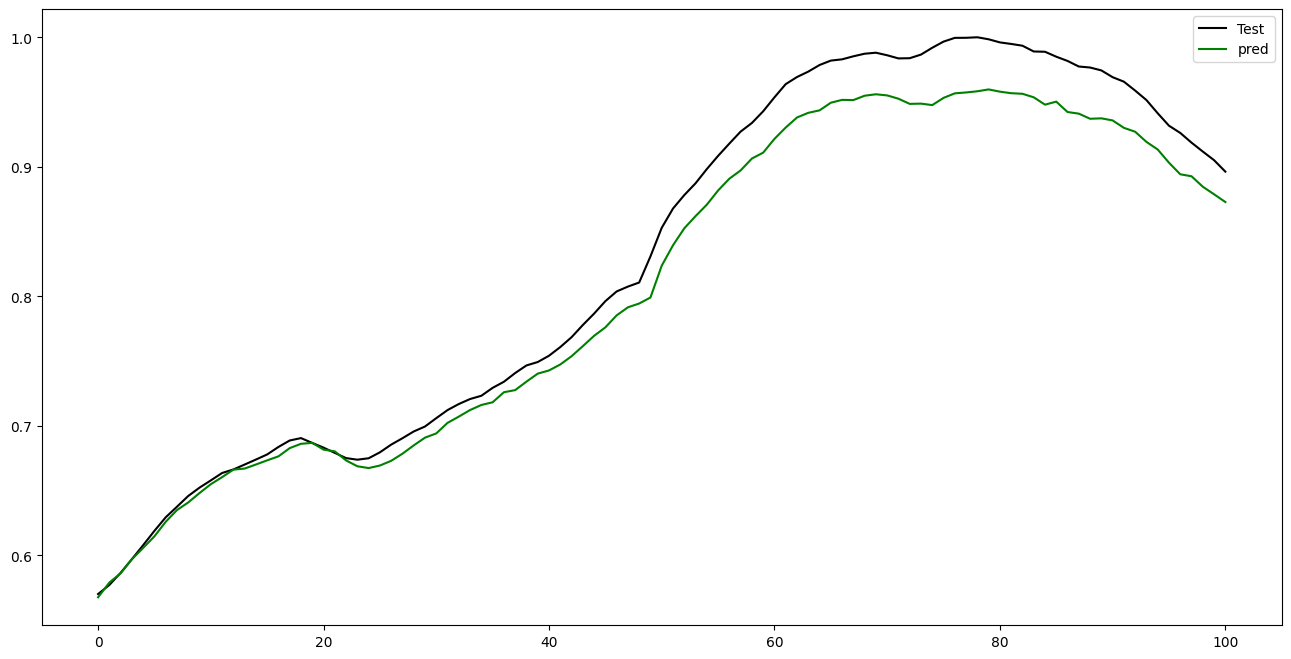

In [ ]:
# plot predicted data
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()